# Mortgage Default ? Fairness Demo (GLM, NN, Adversarial NN)

This notebook mirrors `auto_fairness_demo.ipynb` for the mortgage default DGP. Inputs: observed FICO, LTV, DTI, and ZIP proxy Z. Audit-only: Race A/B and latent FICO_star. Goal: compare GLM, NN, and adversarial NN models and study the accuracy?fairness trade-off.

## 1. Setup

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f'Using project root: {PROJECT_ROOT}')


Using project root: C:\Users\hotfo\bias_mitigation_insurance_pricing


In [2]:
from __future__ import annotations

import numpy as np
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from dataclasses import replace

from src.mortgage.data_generation_mortgage import generate_mortgage_default_data, train_test_split_mortgage
from src.config import TrainingConfig
from src.evaluation.metrics import compute_accuracy_metrics
from src.evaluation.fairness import fairness_metrics, fairness_at_target_rate
from src.models.glm_model import GLMClassifier
from src.models.nn_model import PlainNN, train_plain_nn, predict_proba_plain_nn
from src.models.adv_nn_model import AdvPredictor, train_adv_nn, predict_proba_adv_nn


## 2. Generate Mortgage Data

In [3]:
df = generate_mortgage_default_data(n_samples=100_000, seed=123)
print(f'Dataset size: {len(df):,}')
df.head()


Dataset size: 100,000


,FICO,LTV,DTI,Z,Y,Race,FICO_star
0,578.917835,0.744822,0.588864,1,1,A,607.735621
1,821.109553,0.774112,0.494094,0,0,B,798.126562
2,752.207471,0.871209,0.233149,1,0,B,786.396801
3,673.782714,0.770248,0.234339,0,1,B,624.542692
4,650.423716,0.946359,0.234273,1,0,B,631.664896


## 3. Train/Test Split

In [4]:
df_train, df_test = train_test_split_mortgage(df, seed=123)
print(f'Train size: {len(df_train):,}, Test size: {len(df_test):,}')


Train size: 80,000, Test size: 20,000


### Feature preprocessing

In [5]:
feature_cols_cont = ['FICO', 'LTV', 'DTI']
binary_cols = ['Z']

scaler = StandardScaler()
X_train_cont = scaler.fit_transform(df_train[feature_cols_cont])
X_test_cont = scaler.transform(df_test[feature_cols_cont])

X_train = np.concatenate(
    [X_train_cont, df_train[binary_cols].to_numpy()],
    axis=1
).astype(np.float32)
X_test = np.concatenate(
    [X_test_cont, df_test[binary_cols].to_numpy()],
    axis=1
).astype(np.float32)

y_train = df_train['Y'].to_numpy(dtype=np.float32)
y_test = df_test['Y'].to_numpy(dtype=np.float32)
A_train = (df_train['Race'] == 'A').astype(int).to_numpy(dtype=np.int64)
A_test = (df_test['Race'] == 'A').astype(int).to_numpy(dtype=np.int64)

X_train_glm = X_train
X_test_glm = X_test

train_cfg = TrainingConfig()

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)

def build_loader(X, y, batch_size, shuffle=True):
    ds = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = build_loader(X_tr, y_tr, train_cfg.batch_size, shuffle=True)
val_loader = build_loader(X_val, y_val, train_cfg.batch_size, shuffle=False)
test_loader = build_loader(X_test, y_test, train_cfg.batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train.shape, X_test.shape, device


((80000, 4), (20000, 4), device(type='cpu'))

## 4. GLM Baseline

In [6]:
glm = GLMClassifier().fit(X_train_glm, y_train)
y_proba_glm = glm.predict_proba(X_test_glm)


## 5. Neural Network

In [7]:
plain_nn = PlainNN(input_dim=X_train.shape[1]).to(device)
train_plain_nn(plain_nn, train_loader, val_loader, train_cfg, device)
y_proba_nn = predict_proba_plain_nn(plain_nn, X_test, device=device)


## 6. Adversarial Neural Network

In [8]:
lambda_adv = 0.8
train_cfg_adv = replace(train_cfg, lambda_adv=lambda_adv)

adv_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float(),
    torch.from_numpy(A_train).long(),
)
adv_loader = DataLoader(adv_ds, batch_size=train_cfg.batch_size, shuffle=True)

adv_model = AdvPredictor(input_dim=X_train.shape[1]).to(device)
train_adv_nn(adv_model, adv_loader, train_cfg_adv, device=device)
y_proba_adv = predict_proba_adv_nn(adv_model, X_test, device=device)


Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]


## 7. Evaluation & Fairness (threshold 0.5)

In [9]:
THRESHOLD = 0.50

def summarize(model, y_true, y_proba, A_true, threshold=THRESHOLD):
    acc = compute_accuracy_metrics(y_true, y_proba)
    fair = fairness_metrics(y_true, y_proba, A_true, threshold=threshold)
    return {
        'model': model,
        'threshold': threshold,
        **acc,
        **fair,
    }

summary_default = pd.DataFrame(
    [
        summarize('GLM', y_test, y_proba_glm, A_test),
        summarize('NN', y_test, y_proba_nn, A_test),
        summarize('ADV_NN', y_test, y_proba_adv, A_test),
    ]
)
summary_default


,model,threshold,roc_auc,pr_auc,brier,log_loss,tpr_0,tpr_1,fpr_0,fpr_1,selection_rate_0,selection_rate_1,auc_roc_group0,auc_roc_group1,eo_gap_tpr,eo_gap_fpr,dp_diff,dp_ratio
0,GLM,0.5,0.720066,0.397822,0.143191,0.449140,0.071873,0.161404,0.012018,0.030794,0.023968,0.056978,0.720975,0.730636,0.089531,0.018776,0.033010,2.377220
1,NN,0.5,0.719165,0.391581,0.143846,0.450586,0.012044,0.077895,0.001260,0.011086,0.003413,0.024479,0.720752,0.727073,0.065851,0.009826,0.021066,7.172482
2,ADV_NN,0.5,0.715320,0.390124,0.144214,0.452295,0.034577,0.071579,0.005912,0.009326,0.011635,0.021806,0.714222,0.720418,0.037002,0.003414,0.010171,1.874189


## 8. Fairness at 2% high risk rate

In [10]:
TARGET_RATE = 0.02

def summarize_fixed(model, y_true, y_proba, A_true):
    fair = fairness_at_target_rate(y_true, y_proba, A_true, TARGET_RATE)
    acc = compute_accuracy_metrics(y_true, y_proba)
    return {'model': model, **acc, **fair}

summary_fixed = pd.DataFrame([
    summarize_fixed('GLM', y_test, y_proba_glm, A_test),
    summarize_fixed('NN', y_test, y_proba_nn, A_test),
    summarize_fixed('ADV_NN', y_test, y_proba_adv, A_test),
])
summary_fixed[['model', 'roc_auc', 'eo_gap_tpr', 'eo_gap_fpr', 'dp_diff', 'dp_ratio', 'threshold', 'actual_rate']]


,model,roc_auc,eo_gap_tpr,eo_gap_fpr,dp_diff,dp_ratio,threshold,actual_rate
0,GLM,0.720066,0.071313,0.011253,0.023318,2.990854,0.553691,0.02
1,NN,0.719165,0.091715,0.015699,0.030957,4.440514,0.484009,0.02
2,ADV_NN,0.715320,0.043280,0.005444,0.013060,1.850372,0.489345,0.02


## 9. Plots

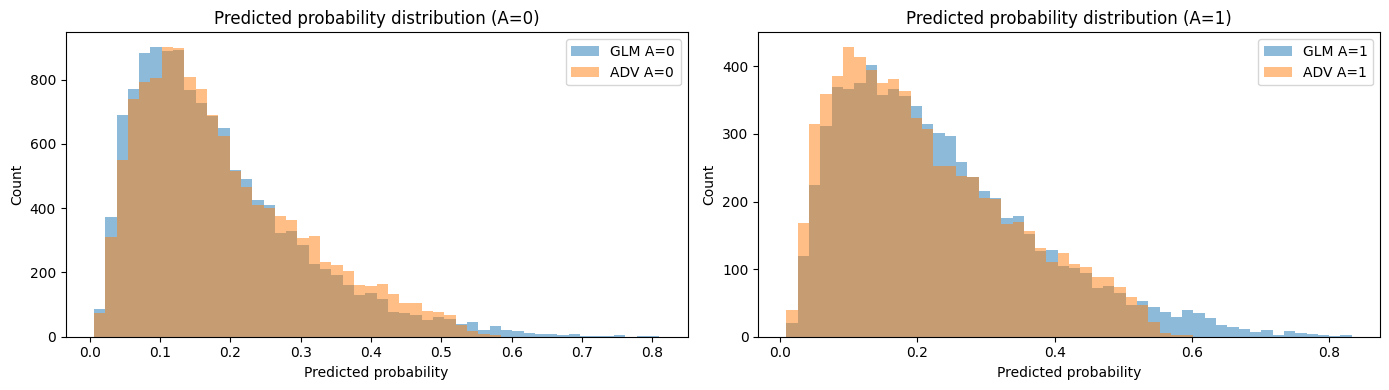

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, group in zip(axes, [0, 1]):
    mask = (A_test == group)

    # Build common bin edges from the union of GLM + ADV scores for this group
    all_scores = np.concatenate([y_proba_glm[mask], y_proba_adv[mask]])
    bins = np.linspace(all_scores.min(), all_scores.max(), 51)  # 50 bins

    # Plot histograms using the same bins
    ax.hist(y_proba_glm[mask], bins=bins, alpha=0.5, label=f"GLM A={group}")
    ax.hist(y_proba_adv[mask], bins=bins, alpha=0.5, label=f"ADV A={group}")

    ax.set_title(f"Predicted probability distribution (A={group})")
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()


### Fairness frontier (EO gap vs ROC AUC)

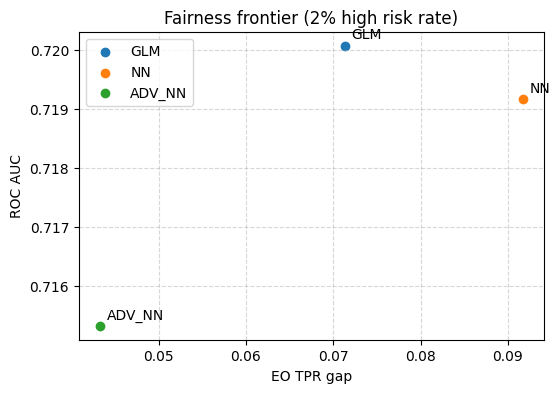

In [12]:
df_frontier = pd.DataFrame({
    'model': summary_fixed['model'],
    'roc_auc': summary_fixed['roc_auc'],
    'eo_gap_tpr': summary_fixed['eo_gap_tpr'],
})
plt.figure(figsize=(6, 4))
for _, row in df_frontier.iterrows():
    plt.scatter(row['eo_gap_tpr'], row['roc_auc'], label=row['model'])
    plt.annotate(row['model'], (row['eo_gap_tpr'], row['roc_auc']), xytext=(5, 5), textcoords='offset points')
plt.xlabel('EO TPR gap')
plt.ylabel('ROC AUC')
plt.title('Fairness frontier (2% high risk rate)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


## 10. Summary

In [13]:
text = (
    "### Key Insights"
    f"- GLM ROC AUC {summary_fixed.loc[summary_fixed.model=='GLM', 'roc_auc'].iat[0]:.3f}; "
    f"EO gap {summary_fixed.loc[summary_fixed.model=='GLM', 'eo_gap_tpr'].iat[0]:.3f}; "
    f"DP ratio {summary_fixed.loc[summary_fixed.model=='GLM', 'dp_ratio'].iat[0]:.2f} at 2% high risk rate."
    f"- NN ROC AUC {summary_fixed.loc[summary_fixed.model=='NN', 'roc_auc'].iat[0]:.3f}; "
    f"EO gap {summary_fixed.loc[summary_fixed.model=='NN', 'eo_gap_tpr'].iat[0]:.3f}; "
    f"DP ratio {summary_fixed.loc[summary_fixed.model=='NN', 'dp_ratio'].iat[0]:.2f}, similar accuracy to GLM."
    f"- ADV_NN (lambda={lambda_adv}) ROC AUC {summary_fixed.loc[summary_fixed.model=='ADV_NN', 'roc_auc'].iat[0]:.3f}; "
    f"EO gap {summary_fixed.loc[summary_fixed.model=='ADV_NN', 'eo_gap_tpr'].iat[0]:.3f}; "
    f"DP ratio {summary_fixed.loc[summary_fixed.model=='ADV_NN', 'dp_ratio'].iat[0]:.2f}, showing the accuracy?fairness trade-off."
)
print(text)


### Key Insights- GLM ROC AUC 0.720; EO gap 0.071; DP ratio 2.99 at 2% high risk rate.- NN ROC AUC 0.719; EO gap 0.092; DP ratio 4.44, similar accuracy to GLM.- ADV_NN (lambda=0.8) ROC AUC 0.715; EO gap 0.043; DP ratio 1.85, showing the accuracy?fairness trade-off.


## 11. Simulated variable distributions

Quick check of the simulated inputs and outcomes.


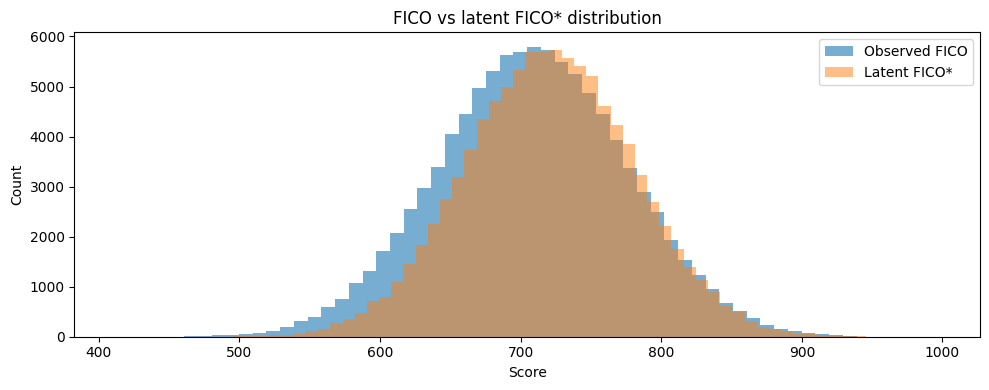

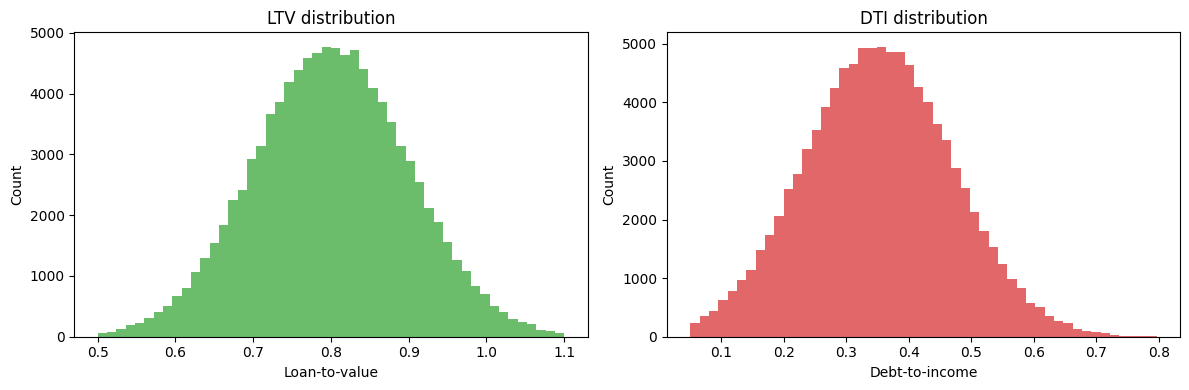

In [14]:
# Continuous variable distributions

# Overlay observed and latent FICO
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(df['FICO'], bins=60, color='tab:blue', alpha=0.6, label='Observed FICO')
ax.hist(df['FICO_star'], bins=60, color='tab:orange', alpha=0.5, label='Latent FICO*')
ax.set_title('FICO vs latent FICO* distribution')
ax.set_xlabel('Score')
ax.set_ylabel('Count')
ax.legend()
plt.tight_layout()
plt.show()

# Separate figure for LTV and DTI
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df['LTV'], bins=50, color='tab:green', alpha=0.7)
axes[0].set_title('LTV distribution')
axes[0].set_xlabel('Loan-to-value')
axes[0].set_ylabel('Count')
axes[1].hist(df['DTI'], bins=50, color='tab:red', alpha=0.7)
axes[1].set_title('DTI distribution')
axes[1].set_xlabel('Debt-to-income')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()


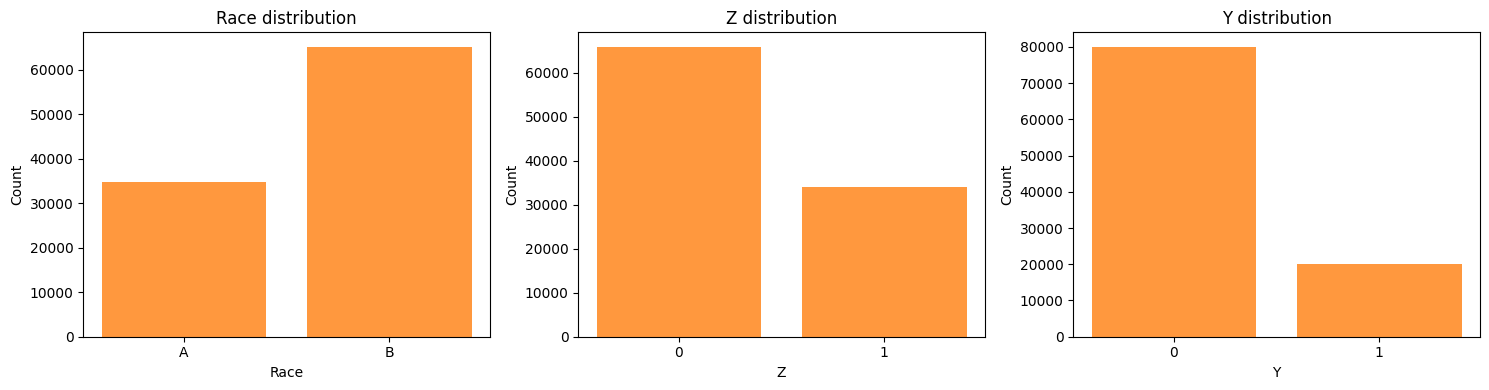

In [15]:
categorical_features = {
    'Race': df['Race'],
    'Z': df['Z'],
    'Y': df['Y'],
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (col, series) in zip(axes, categorical_features.items()):
    counts = series.value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values, color='tab:orange', alpha=0.8)
    ax.set_title(f"{col} distribution")
    ax.set_ylabel('Count')
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()


## 12. Fairness plots with experiment helpers

Sweep adversarial lambdas for the frontier, and evaluate five candidate high risk rates.

Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]
Epoch 0 [warmup]
Epoch 1 

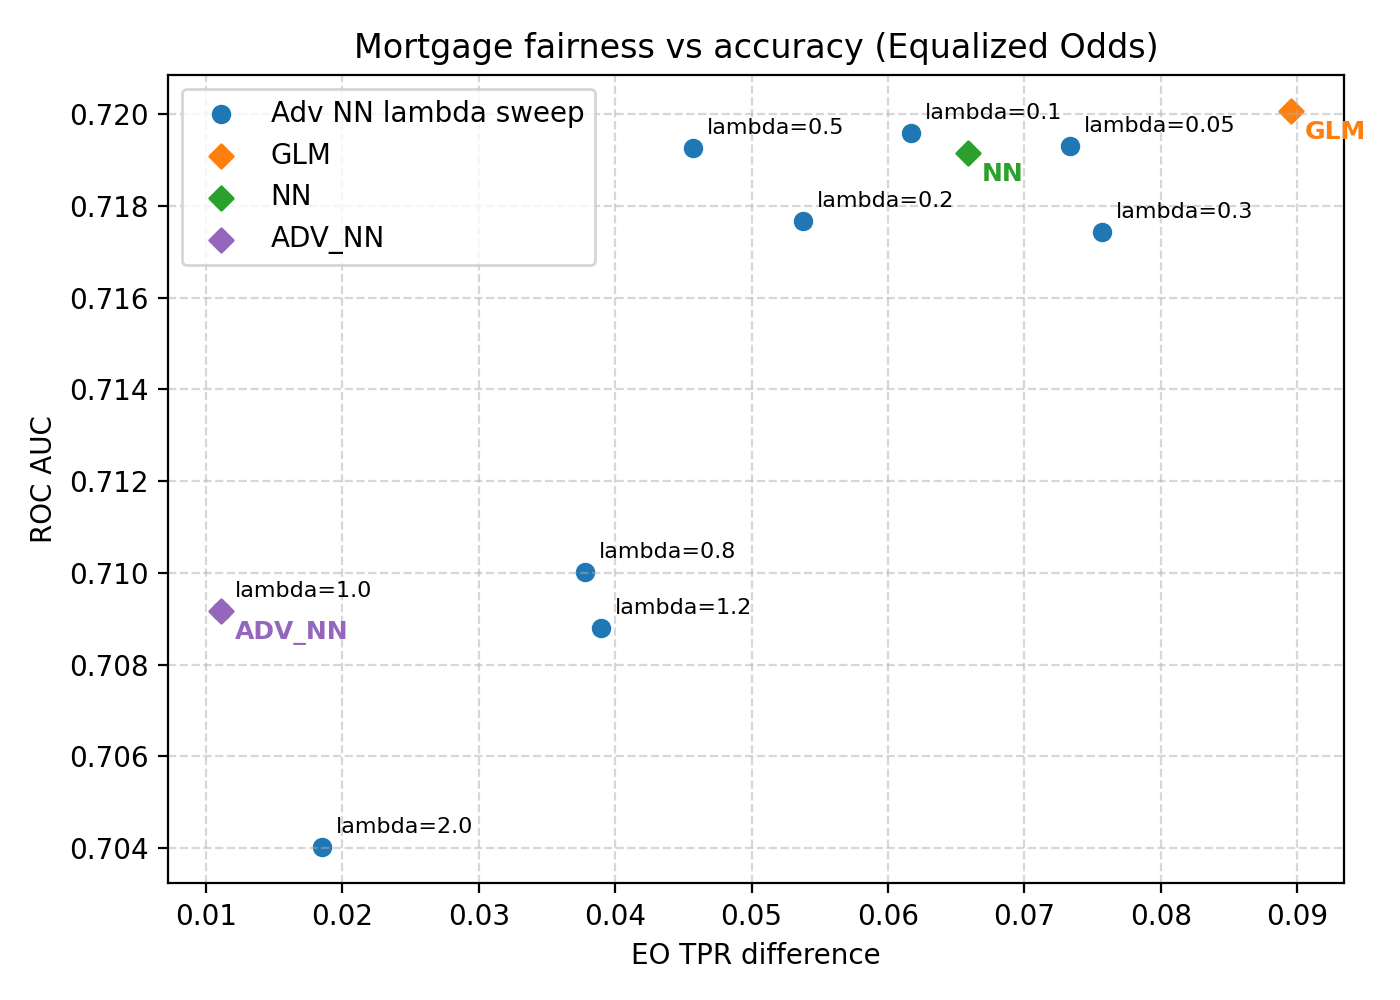

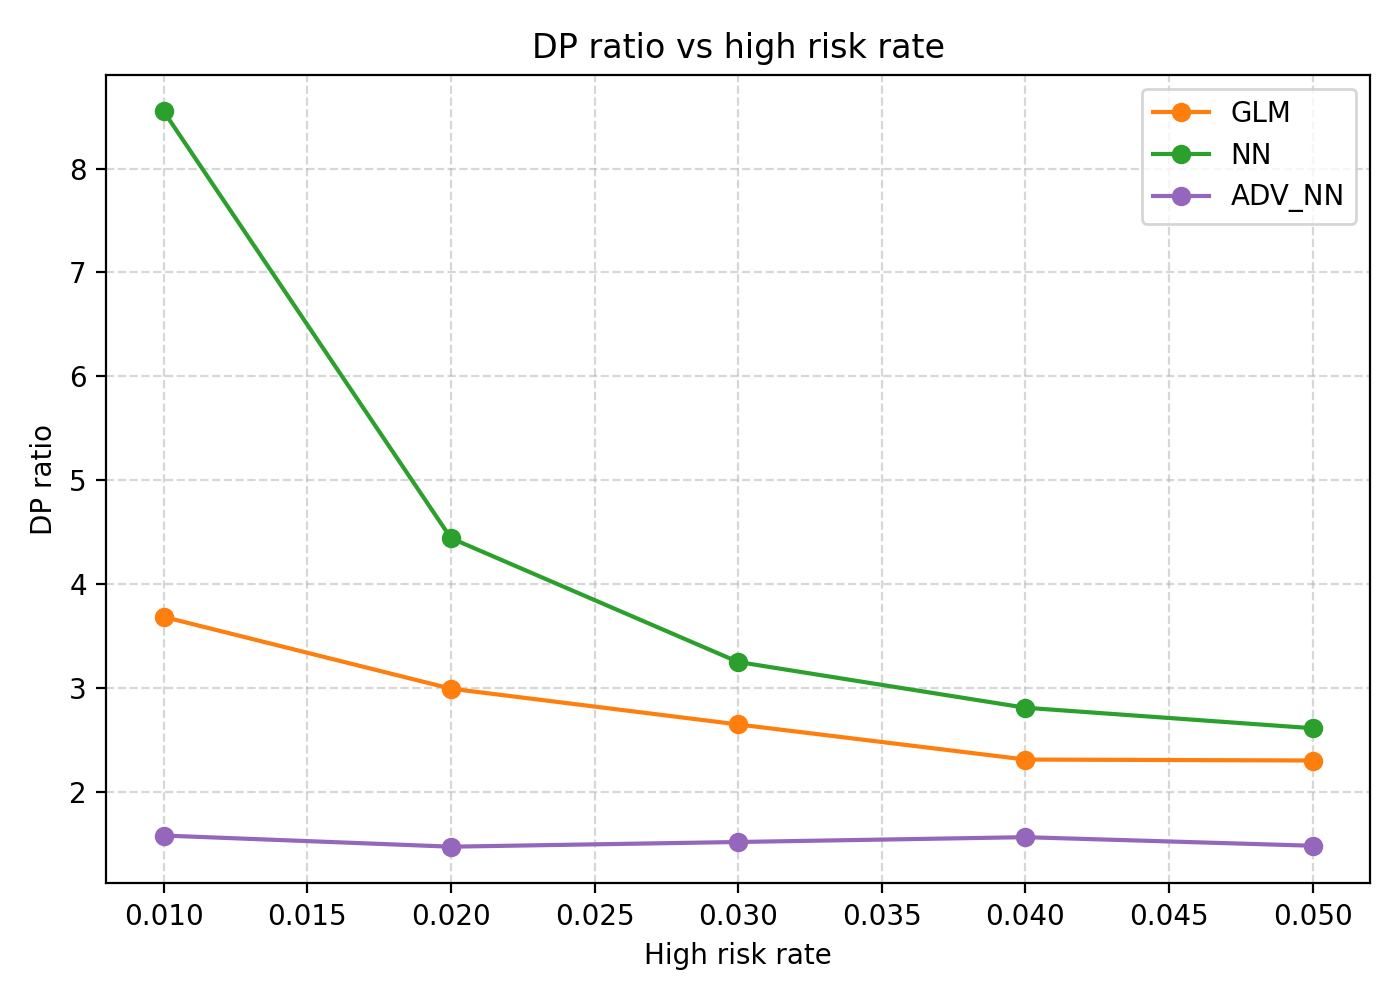

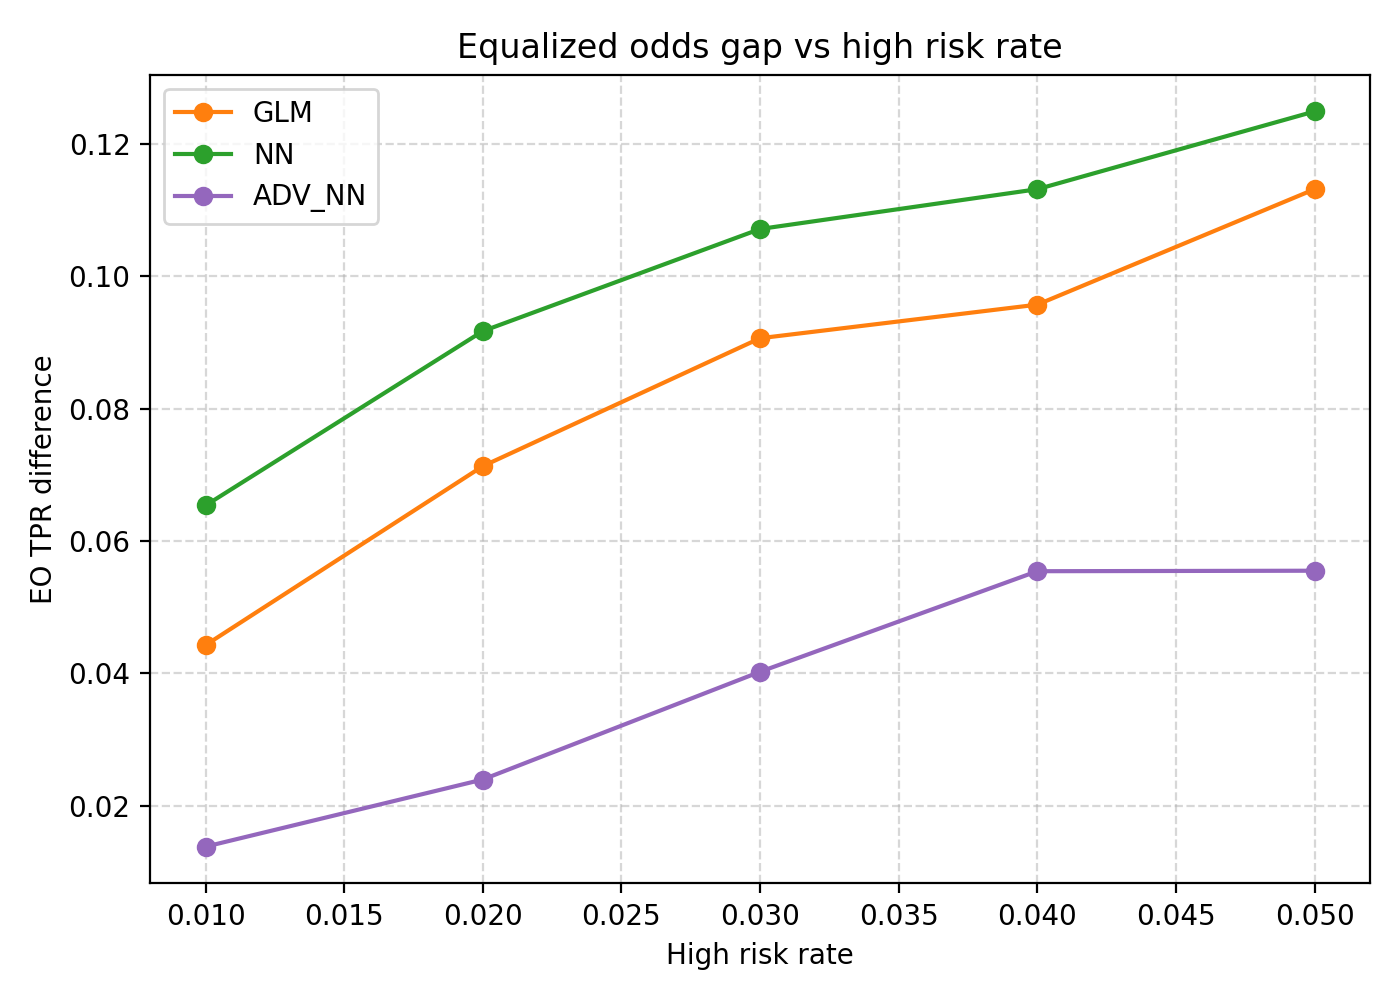

In [16]:
from IPython.display import Image, display
from src.experiments.mortgage.plot_fairness_accuracy_frontier import plot_fairness_accuracy_frontier
from src.experiments.mortgage.plot_fairness_vs_rate import plot_fairness_vs_rate

lambda_candidates = [0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0, 1.2, 2.0]
candidate_rates = [0.01, 0.02, 0.03, 0.04, 0.05]

adv_results = []
adv_proba_by_lambda = {}
for lam in lambda_candidates:
    cfg = replace(train_cfg, lambda_adv=lam)
    adv_model = AdvPredictor(input_dim=X_train.shape[1]).to(device)
    adv_loader = DataLoader(adv_ds, batch_size=train_cfg.batch_size, shuffle=True)
    train_adv_nn(adv_model, adv_loader, cfg, device=device)
    y_proba_lam = predict_proba_adv_nn(adv_model, X_test, device=device)
    adv_proba_by_lambda[lam] = y_proba_lam
    fair = fairness_metrics(y_test, y_proba_lam, A_test, threshold=THRESHOLD)
    acc = compute_accuracy_metrics(y_test, y_proba_lam)
    adv_results.append({
        'lambda_adv': lam,
        'roc_auc': acc['roc_auc'],
        'eo_gap_tpr': fair['eo_gap_tpr'],
    })

df_lambda = pd.DataFrame(adv_results).sort_values('lambda_adv')
df_lambda['score'] = df_lambda['roc_auc'] - df_lambda['eo_gap_tpr']
best_lambda = df_lambda.loc[df_lambda['score'].idxmax(), 'lambda_adv']
best_metrics = df_lambda[df_lambda['lambda_adv'] == best_lambda].iloc[0]
y_proba_best_adv = adv_proba_by_lambda[best_lambda]

df_fixed_frontier = pd.DataFrame([
    {
        'model_name': 'GLM',
        'roc_auc': summary_default.loc[summary_default.model=='GLM', 'roc_auc'].iat[0],
        'eo_gap_tpr': summary_default.loc[summary_default.model=='GLM', 'eo_gap_tpr'].iat[0],
    },
    {
        'model_name': 'NN',
        'roc_auc': summary_default.loc[summary_default.model=='NN', 'roc_auc'].iat[0],
        'eo_gap_tpr': summary_default.loc[summary_default.model=='NN', 'eo_gap_tpr'].iat[0],
    },
    {
        'model_name': 'ADV_NN',
        'roc_auc': best_metrics['roc_auc'],
        'eo_gap_tpr': best_metrics['eo_gap_tpr'],
    },
])

def summarize_at_rates(model_name, y_proba):
    rows = []
    for rate in candidate_rates:
        fair = fairness_at_target_rate(y_test, y_proba, A_test, rate)
        acc = compute_accuracy_metrics(y_test, y_proba)
        rows.append({
            'model_name': model_name,
            'target_rate': rate,
            **fair,
            **acc,
        })
    return rows

rows = []
rows.extend(summarize_at_rates('GLM', y_proba_glm))
rows.extend(summarize_at_rates('NN', y_proba_nn))
rows.extend(summarize_at_rates('ADV_NN', y_proba_best_adv))
df_fixed_rates = pd.DataFrame(rows)

frontier_path = plot_fairness_accuracy_frontier(df_lambda, df_fixed_frontier)
dp_path, eo_path = plot_fairness_vs_rate(df_fixed_rates)

print(f'Selected lambda for balance: {best_lambda:.2f}')
display(Image(filename=frontier_path))
display(Image(filename=dp_path))
display(Image(filename=eo_path))
